In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, shutil, sklearn

from modules import WineDb
from modules.PreprocessingFunctions import Functions as prep

if os.path.exists('modules\__pycache__'):
    shutil.rmtree('modules\__pycache__')

In [2]:
winedb = WineDb.WineDb()
winedb().head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


# Binary Classification

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Pipelines
def pipeline1(x, excluded):
    output = prep.minmax_norm(x, excluded)
    return output

def pipeline2(x, excluded):
    x = prep.zscore_outliers(x, 4, excluded)
    output = prep.minmax_norm(x, excluded)
    return output

def pipeline3(x, excluded):
    x = prep.isoforest_outliers(x, excluded)
    x = prep.smote(x)
    output = prep.standard_norm(x, excluded)
    return output

def pipeline4(x, excluded):
    x = prep.minmax_norm(x, excluded)
    output = prep.pca(x, excluded)
    return output


# Train/Test/Split and fit auxiliary functions
def get_split_data(input_db, excluded, target, test_size=0.33):
    excluded_col = excluded+target
    x = input_db.loc[:,input_db.columns.difference(excluded_col)]
    y = input_db.loc[:,target][target[0]]
    
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.4, random_state = 42)
    
    return x_train, x_test, y_train, y_test

def fit_and_test(args):
    x_train, x_test, y_train, y_test = args
    randforest = RandomForestClassifier()
    randforest.fit(x_train, y_train)
    pred = randforest.predict(x_test)
    
    return confusion_matrix(y_test, pred)

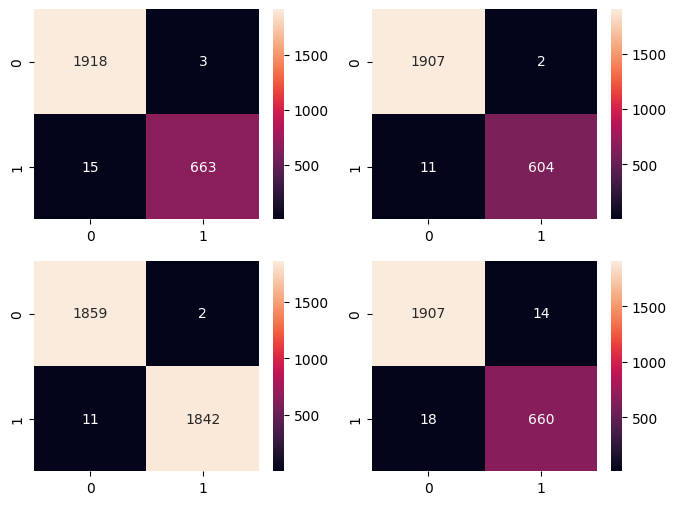

In [50]:
target_col = ['type']
excluded_col = ['alcohol', 'quality']

dbs = {
    'pipeline_1':pipeline1(winedb(), target_col),
    'pipeline_2': pipeline2(winedb(), target_col),
    'pipeline_3': pipeline3(winedb(), target_col),
    'pipeline_4': pipeline4(winedb(), target_col)
       }

f, ax = plt.subplots(2,2, figsize=(8, 6))

xind,yind = 0, 0

for key in dbs:
    sns.heatmap(fit_and_test(get_split_data(dbs[key], excluded_col, target_col)), ax = ax[yind, xind],  annot=True,fmt="d")
    if xind < 1: 
        xind+=1
    else: 
        xind=0
        yind+=1

# Regression (and SVM)

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import cross_val_score

In [60]:
input_db = winedb()

In [61]:
regressor = LinearRegression()

x_train, x_test, y_train, y_test = get_split_data(input_db, [], ['quality'])

regressor.fit(x_train, y_train)
print(cross_val_score(regressor, x_train, y_train, scoring='neg_mean_absolute_percentage_error'))
preds = regressor.predict(x_test)

[-0.09952346 -0.10116262 -0.10017277 -0.10833307 -0.09363466]


In [62]:
print(regressor.score(x_test, y_test))
print(f'MSE: {sum(y_test - preds)**2/len(y_test)}')

0.2802786544177982
MSE: 0.1056651718936176


In [63]:
regressor = BayesianRidge()

x_train, x_test, y_train, y_test = get_split_data(input_db, [], ['quality'])

regressor.fit(x_train, y_train)
print(cross_val_score(regressor, x_train, y_train, scoring='neg_mean_absolute_percentage_error'))
preds = regressor.predict(x_test)

[-0.10058809 -0.10150046 -0.10053519 -0.10850582 -0.09338605]


In [64]:
print(regressor.score(x_test, y_test))
print(f'MSE: {sum(y_test - preds)**2/len(y_test)}')

0.2752421666972803
MSE: 0.132714547951243
